In [1]:
import os
import random

import cv2 as cv
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

2024-07-24 07:33:22.329876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 07:33:22.329987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 07:33:22.455673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGES_DIR = "/kaggle/input/airbus-ship-detection/train_v2"
MASKS_CSV_DIR = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"

In [3]:
# read the csv file
df = pd.read_csv(MASKS_CSV_DIR)

In [4]:
def wrangle():
    # read the csv file
    df = pd.read_csv(MASKS_CSV_DIR)
    
    # merged the encoded pixels of the same image ids into a single row.
    df = df.groupby("ImageId")["EncodedPixels"].apply(lambda x: ' '.join(x.dropna())).reset_index()
    df["EncodedPixels"] = df["EncodedPixels"].replace("", np.nan)
    
    # select images that doesn't have any instances.
    background_imgs = df[df.isna().any(axis=1)]

    # Randomly select rows to drop
    droped_rows = background_imgs.sample(n=int(0.99 * len(background_imgs))).index # drop 99% of images that don't contains any instances.

    # drop the selected rows form the dataframe
    df = df.drop(droped_rows)
    
    return df

In [5]:
df = wrangle()

In [6]:
df = df.sample(n=10000)

In [7]:
def rle2mask(mask_rle, shape):
    """
    Converts a run-lenght-encoder (RLE) string to a binary mask.

    Args:
        mask_rle: Run-length encoded string
        shape: Tuple (height, width) of the output mask.

    Returns:
        binary mask of the given shape.
    """

    # split the RLE string and convert to integres.
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]

    # Adjust starts to be zero-indexed
    starts -= 1
    # Compute the ending positions of the runs
    ends = starts + lengths

    # Initialize the mask with zeros
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)

    # Set the pixels within the runs to 1
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    # Reshape the flat array to the specified shape
    return img.reshape((shape[1], shape[0])).T

In [8]:
SEED = 42
BATCH = 8
LEARNING_RATE = 0.001
NUM_CLASSES = 1
IMG_SHAPE = (512, 512)
EPOCHS=20

## Split the Dataset

In [9]:
# split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
print(f"Total Training size: {len(train_df)}")
print(f"Total Validation size: {len(val_df)}")

Total Training size: 8000
Total Validation size: 2000


## Preprocess the dataset

In [11]:
def generator(dataframe, images_dir, img_shape):
    def _generator():            
        for i, (_, row) in enumerate(dataframe.iterrows()):
            image_path = f"{images_dir}/{row.ImageId}"
            # Read the image
            image = cv.imread(image_path)
            
            # Check if there are encoded pixels for the mask
            if not pd.isna(row.EncodedPixels):
                # Convert encoded mask to a binary mask
                mask = rle2mask(row.EncodedPixels, image.shape[:2])
            else:
                # If no encoded pixels, create an empty mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
            
            # Resize the image
            image = cv.resize(image, img_shape)
            
            # Resize the mask
            mask = cv.resize(mask, img_shape, interpolation=cv.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1)

            yield image, mask
    return _generator

In [12]:
def create_tf_dataset(dataframe, images_dir, img_shape, batch):
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_generator(
        generator(dataframe, images_dir, img_shape),
        output_signature=(
            tf.TensorSpec(shape=(img_shape[0], img_shape[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(img_shape[0], img_shape[1], 1), dtype=tf.float32)
        )
    )

    # Batch the dataset and prefetch for better performance
    dataset = dataset.batch(batch).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [13]:
# create tensorflow dataset
train_dataset = create_tf_dataset(train_df, IMAGES_DIR, IMG_SHAPE, BATCH)
val_dataset = create_tf_dataset(val_df, IMAGES_DIR, IMG_SHAPE, BATCH)

## Build the Model

In [14]:
def conv_block(inputs, num_filters):
    # implementing the first conv block.
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer="he_normal")(inputs)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.Activation('relu')(batch_norm)

    # implementing the second conv block.
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(act)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.Activation("relu")(batch_norm)

    return act

In [15]:
def encoder_block(inputs, num_filters):    
    skip = conv_block(inputs, num_filters) # convolutional block
    max_pool = tf.keras.layers.MaxPooling2D((2,2))(inputs) # pooling  block

    return skip, max_pool

In [16]:
def decoder_block(inputs, skip, num_filters):
    # upsampling and concatenating the input features.
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2,2), padding='same')(inputs)  # upsampling block
    connect_skip = tf.keras.layers.concatenate([upsample, skip])
    out = conv_block(connect_skip, num_filters)

    return out

In [17]:
def build_unet(n_classes: int, height: int, width: int, channel: int):

    inputs = tf.keras.layers.Input((height, width, channel))

    # Defining the encoder (down sampler)
    skip1, max_pool1 = encoder_block(inputs, num_filters=64)
    skip2, max_pool2 = encoder_block(max_pool1, num_filters=128)
    skip3, max_pool3 = encoder_block(max_pool2, num_filters=256)
    skip4, max_pool4 = encoder_block(max_pool3, num_filters=512)
    
    # Defining the bottleneck
    bridge = conv_block(max_pool4, num_filters=1024)

    # Defining the decoder (up sampler)
    u4 = decoder_block(bridge, skip4, num_filters=512)
    u3 = decoder_block(u4, skip3, num_filters=256)
    u2 = decoder_block(u3, skip2, num_filters=128)
    u1 = decoder_block(u2, skip1, num_filters=64)

    # output function
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='sigmoid')(u1)
    
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name="Unet")

    return model

## Metrics

In [18]:
def dice_coeff(y_true, y_pred, smooth = 1e-6):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred, axis=-1)
    union = tf.keras.backend.sum(y_true, axis=-1) + tf.keras.backend.sum(y_pred, axis=-1)
    dice_coeff = (2 * intersection + smooth) / (union + smooth)

    return dice_coeff

In [19]:
def dice_coeff_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

## Compile and fit the Model

In [20]:
EPOCHS=30
initial_lr = 0.001
final_lr = 0.00001

In [21]:
def tune_learning_rate(model, train_data):
    # set learning rate scheduler
    lr_schedule = lambda epoch: initial_lr * (final_lr / initial_lr) ** (epoch / EPOCHS)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-06),
        loss = [dice_coeff_loss],
        metrics=[dice_coeff])

    history = model.fit(train_data, epochs=EPOCHS, callbacks=[lr_scheduler])

    return history


In [22]:
# build the model
model = build_unet(n_classes=NUM_CLASSES, height=IMG_SHAPE[0], width=IMG_SHAPE[1], channel=3)

In [23]:
# compile and fit the model
history = tune_learning_rate(model=model, train_data=train_dataset)

Epoch 1/30


2024-07-24 07:34:21.563114: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.37599, expected 3.38235
2024-07-24 07:34:21.563183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.67496, expected 4.68133
2024-07-24 07:34:21.563192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.02051, expected 5.02687
2024-07-24 07:34:21.563200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.32685, expected 4.33322
2024-07-24 07:34:21.563208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.93495, expected 3.94132
2024-07-24 07:34:21.563216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.2295, expected 4.23587
2024-07-24 07:34:21.563223: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.39933, expected 3.40569
2024-07-24 07:34:21.563231: E external/local_xla/xla/ser

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 814s 697ms/step - dice_coeff: 0.3086 - loss: 0.6914 - learning_rate: 0.0010
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 699s 699ms/step - dice_coeff: 0.5212 - loss: 0.4788 - learning_rate: 8.5770e-04
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 700s 700ms/step - dice_coeff: 0.5599 - loss: 0.4401 - learning_rate: 7.3564e-04
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 701s 701ms/step - dice_coeff: 0.5939 - loss: 0.4061 - learning_rate: 6.3096e-04
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 701s 701ms/step - dice_coeff: 0.6206 - loss: 0.3794 - learning_rate: 5.4117e-04
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 701s 701ms/step - dice_coeff: 0.6457 - loss: 0.3543 - learning_rate: 4.6416e-04
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 701s 701ms/step - dice_coeff: 0.6644 - loss: 0.3356 - learning_rate: 3.9811e-04
Epoch 8/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 701s 701ms/step - dice_coeff: 0.6865 - loss: 0.3135 - learning_rate: 3.4145e-04
Epoch 9/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 701s 701ms/step - dice_coeff: 0.7033 - loss: 0.2967 - learning_rate: 2.9286e-04
Epoch 10/30
1000/1000 ━━━━━━━━━━━━━

In [24]:
def plot_learning_rate(history):
    plt.figure(figsize=(10, 6))
    plt.semilogx(history.history['learning_rate'], history.history['loss'])
#     plt.plot(history.history['learning_rate'], history.history['loss'])
    plt.tick_params('both', length=10, width=1, which='both')
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Learning Rate")
    plt.grid(True)
    plt.savefig('Learning_rate.jpg')


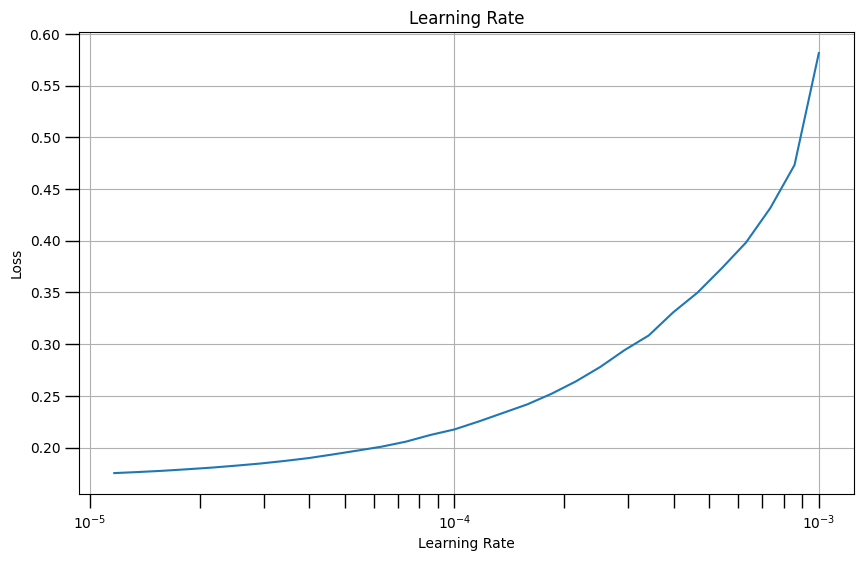

In [25]:
plot_learning_rate(history)